# Guided fitting using surface graphs

Fitting multi modal data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

The source of the data used is a LinkedIn post [5].

## Set-up

In [1]:
alias Chi2fit.Collector, as: C
alias Chi2fit.Distribution, as: D
alias D.Utilities, as: DU
alias Chi2fit.Fit, as: F
alias Chi2fit.Statistics, as: S
alias Chi2fit.Utilities, as: U
alias Chi2fit.Gnuplotlib, as: G

Chi2fit.Gnuplotlib

## Data and simulation set-up

As an example consider the lead time of work items.

In [2]:
data = [{2,30},{4,20},{6,50},{8,35},{10,27},{12,11},{14,20},{16,16},{18,2}]
|> Enum.map(fn {x,count}->List.duplicate(x-0.001,count) end)
|> Enum.concat
:"do not show this result in output"

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [3]:
# Number of iterations to use in the chi-squared fit
iterations = 1000

# The size of bins for grouping the data
binsize = 2

# Number of probes to use in the chi-squared fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = [{0.1,100},{0.1,100}]
:"do not this result in output"

:"do not this result in output"

## Preparation

Next, we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0.

In [4]:
hdata = S.to_bins data, {binsize,0}
:"do not show this result in output"

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

## Fitting the data to a Weibull distribution

The code below uses basic settings of the commands provided by `Chi2Fit`. More advanced options can be found at [2]. First a fixed number of random parameter values are tried to get a rough estimate. The option `probes` equals the number of tries. Furthermore, since we are fitting a probability distribution which has values on the interval `[0,1]` the errors are asymmetrical. This is specified by the option `linear`. 

In [5]:
# Start the collector to capture the xyz data
{:ok, pid} = C.start_link
C.collect()

model = DU.model "weibull"
options = [probes: 50_000, smoothing: false, model: :linear, saved?: true, surfacefile: pid]
initial = [{0.1,1.5},{7.5,8.5}]
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {D.cdf(model), &F.nopenalties/2}, options

xyz = C.value()
C.stop()

U.display result

Initial guess:
    chi2:		30.14091407456487
    pars:		[1.4999863312919066, 7.5451517233389485]
    ranges:		{[1.4915259696441225, 1.4999863312919066], [7.500020402953681, 7.710649702122768]}



:ok

The errors reported is the found range of parameter values where the corresponding `chi2` values are within 1 of the found minimum value.

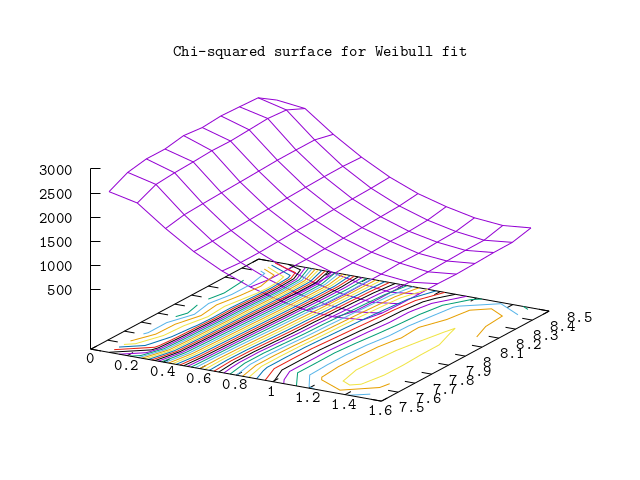

In [6]:
xyz
|> Enum.map(&(&1|>String.replace("\n","")|>String.split(","))|>Enum.map(fn str -> Float.parse(str)|>elem(0) end))
|> G.surface(plottitle: "Chi-squared surface for Weibull fit")
:"this is an inline image"

After roughly locating the minimum we do a more precise (and computationally more expensive) search for the minimum.

In [34]:
# Set new initial parameters based on the surface chart
initial = [{1.25,1.45},{7.5,8.5}]

# Start the collector to capture the xyz data
{:ok, pid} = C.start_link
C.collect()

options = [probes: 50_000, smoothing: false, model: :linear, saved?: true, surfacefile: pid]
result = {_,parameters,_,saved} = F.chi2probe hdata, initial, {D.cdf(model), &F.nopenalties/2}, options

xyz = C.value()
:ok = C.stop()

U.display result

Initial guess:
    chi2:		36.60408730449069
    pars:		[1.44998891180416, 7.505412937291439]
    ranges:		{[1.443813115509482, 1.44998891180416], [7.500777641522675, 7.6177328024855555]}



:ok

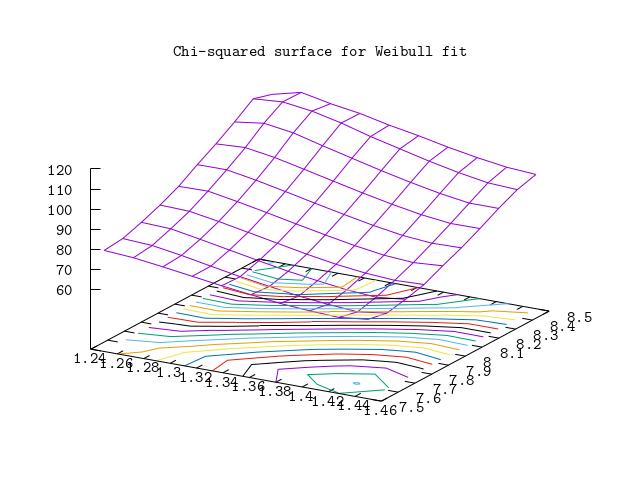

In [35]:
xyz
|> Enum.map(&(&1|>String.replace("\n","")|>String.split(","))|>Enum.map(fn str -> Float.parse(str)|>elem(0) end))
|> G.surface(plottitle: "Chi-squared surface for Weibull fit")
:"this is an inline image"

## The CDF and PDF for the fitted distribution

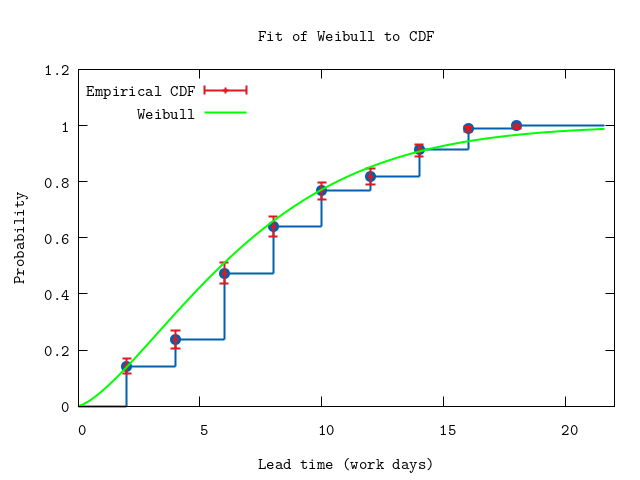

In [40]:
parameters = [1.42,7.6]
G.ecdf(hdata,
    plottitle: "Fit of Weibull to CDF",
    xlabel: "Lead time (work days)",
    ylabel: "Probability",
    xrange: '[0:22]',
    title: "Weibull",
    func: & D.cdf(model).(&1,parameters))
:"this is an inline image"

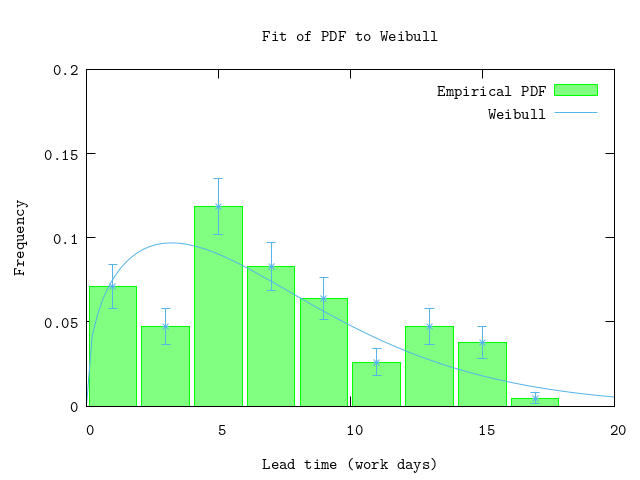

In [39]:
pdf = fn x -> D.pdf(model).(x,parameters) end
G.pdf(data|>Enum.map(&(&1-0)),
    plottitle: "Fit of PDF to Weibull",
    xlabel: "Lead time (work days)",
    ylabel: "Frequency",
    yrange: '[0:0.20]',
    xrange: '[0:20]',
    pdf: pdf,
    bin: binsize,
    title: "Weibull")
:"this is an inline image"

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf<br>
[5] Niladri Bose, LinkedIn post, August 2020